In [2]:
#!pip install pandasql 
from pandasql import sqldf 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [12]:
game_data = pd.read_excel(r'C:\Users\vasaa\data2\Data Challenge Master File.xlsx', sheet_name='Single Game Sales and Scans')
UCP_Scans = pd.read_excel(r'C:\Users\vasaa\data2\Data Challenge Master File.xlsx', sheet_name='UCP Scans')
UCP_Reservations = pd.read_excel(r'C:\Users\vasaa\data2\Data Challenge Master File.xlsx', sheet_name='UCP Reservations')
UCP_Member_Report = pd.read_excel(r'C:\Users\vasaa\data2\Data Challenge Master File.xlsx', sheet_name='UCP Member Report')


In [ ]:
Data_Dictionary = pd.read_excel('/content/Data Challenge Master File.xlsx', sheet_name='Data Dictionary')
team = pd.read_excel('/content/Data Challenge Master File.xlsx', sheet_name='Team Data')


In [5]:
pysqldf = lambda q: sqldf(q, globals())

# Do evening games (6:00pm or later) on average, have a higher scanned attendance than afternoon games (Before 6:00pm)?

In [1118]:
query1="""WITH game_attendance AS (
  SELECT 
    event_datetime,
    event_name,
    CASE 
      WHEN strftime('%H', event_datetime) < '18' THEN 'Afternoon' 
      ELSE 'Evening' 
    END as game_time,
    COUNT(scan_datetime) AS total_attendance
  FROM game_data
  GROUP BY event_datetime, event_name, game_time
)

SELECT 
  game_time,
  ROUND(AVG(total_attendance)) AS avg_attendance
FROM game_attendance
GROUP BY game_time;
"""

In [1119]:
pysqldf(query1)

,game_time,avg_attendance
0,Afternoon,1435.0
1,Evening,2132.0


## Also, provide average attendance per game by month

In [1148]:
query2="""SELECT 
  month,
  ROUND(AVG(total_attendance)) AS avg_attendance_per_game
FROM (
  SELECT 
    strftime('%m', event_datetime) AS month,
    event_name,
    COUNT(scan_datetime) AS total_attendance
  FROM 
    game_data
  GROUP BY 
    month, event_name
) subquery
GROUP BY 
  month;
"""

In [1149]:
pysqldf(query2)

,month,avg_attendance_per_game
0,01,2082.0
1,02,2682.0
2,03,2181.0
3,04,4363.0
4,10,1429.0
5,11,1632.0
6,12,1459.0


# Count the number of UCP members with reservations >=5 and scans >=3. 

In [728]:
query3="""SELECT COUNT(*) FROM(SELECT *
FROM UCP_Reservations AS r
JOIN UCP_Scans AS s ON r.EVENT_DATE_LOCAL = s.event_datetime AND r.SECTION = s.section_name AND r.ROW = s.row_name AND r.SEAT = s.seat_number
JOIN UCP_Member_Report AS m ON r.TENANT_MEMBER_NUMBER = m.TENANT_MEMBER_NUMBER
WHERE r.TENANT_MEMBER_NUMBER != '1000-000-0000'
GROUP BY r.TENANT_MEMBER_NUMBER
HAVING COUNT(DISTINCT r.TICKET_ID) >= 5 AND COUNT(DISTINCT s.scan_datetime) >= 3)
"""

In [729]:
pysqldf(query3)

,COUNT(*)
0,330


# Of these, how many UCP members attended every game they reserved?

In [730]:
query4='''
WITH Reservations AS (
    SELECT TENANT_MEMBER_NUMBER, COUNT(TICKET_ID) AS reservation_count
    FROM UCP_Reservations
    WHERE TENANT_MEMBER_NUMBER != '1000-000-0000'
    GROUP BY TENANT_MEMBER_NUMBER
),
Scans AS (
    SELECT UCP_Reservations.TENANT_MEMBER_NUMBER, COUNT(UCP_Scans.scan_datetime) AS scan_count
    FROM UCP_Reservations
    JOIN UCP_Scans ON UCP_Reservations.EVENT_DATE_LOCAL = UCP_Scans.event_datetime
        AND UCP_Reservations.SECTION = UCP_Scans.section_name
        AND UCP_Reservations.ROW = UCP_Scans.row_name
        AND UCP_Reservations.SEAT = UCP_Scans.seat_number
    WHERE UCP_Reservations.TENANT_MEMBER_NUMBER != '1000-000-0000'
    GROUP BY UCP_Reservations.TENANT_MEMBER_NUMBER
),
MemberData AS (
    SELECT Reservations.TENANT_MEMBER_NUMBER, reservation_count, scan_count
    FROM Reservations
    JOIN Scans ON Reservations.TENANT_MEMBER_NUMBER = Scans.TENANT_MEMBER_NUMBER
    WHERE reservation_count >= 5 AND scan_count >= 3
)

SELECT COUNT(*) AS total_members
FROM MemberData
WHERE reservation_count = scan_count;
'''

In [731]:
pysqldf(query4)

,total_members
0,26


# Find the average cost of a single game ticket for each game in the dataset provided.

In [732]:
query5 = '''
    SELECT event_name, AVG(price) AS avg_price
    FROM game_data
    GROUP BY event_name
'''

In [733]:
pysqldf(query5)

,event_name,avg_price
0,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,31.966790
1,LA Clippers 2022-23 Game 10 - Utah 11/21/22,19.911941
2,LA Clippers 2022-23 Game 11 - Denver 11/25/22,31.697708
3,LA Clippers 2022-23 Game 12 - Indiana 11/27/22,19.672161
4,LA Clippers 2022-23 Game 13 - Sacramento 12/3/22,23.143322
5,LA Clippers 2022-23 Game 14 - Boston 12/12/22,40.391410
6,LA Clippers 2022-23 Game 15 - Minnesota 12/14/22,17.140794
7,LA Clippers 2022-23 Game 16 - Phoenix 12/15/22,21.590062
8,LA Clippers 2022-23 Game 17 - Washington 12/17/22,21.790625
9,LA Clippers 2022-23 Game 18 - Charlotte 12/21/22,25.266808


# Then compare the total value if all UCP eligible games were purchased at their average single game price, against the UCP package price. Assume the UCP package price is $350. 

In [ ]:
# Excluding the 6 games which are not available in the UCP 

In [1146]:
query6 = '''SELECT ROUND(SUM(avg_price) - (78.283906 + 27.499471 + 83.415429 + 46.151941 + 84.752982 + 159.001586),0) as total_value
FROM(
    SELECT event_name, AVG(price) AS avg_price
    FROM game_data
    GROUP BY event_name) AS avg_CTE
'''

In [1147]:
pysqldf(query6)

,total_value
0,861.0


## Scraping data from basketball-reference

In [1297]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.basketball-reference.com/teams/LAC/2023_games.html'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

table = soup.find('table', {'id': 'games'})

headers = []
for th in table.find_all('th'):
    headers.append(th.text)
    
rows = []
for tr in table.find_all('tr')[1:]:
    row = []
    for td in tr.find_all('td'):
        row.append(td.text)
    rows.append(row)



In [1298]:
df = pd.DataFrame(rows)

In [1299]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,"Thu, Oct 20, 2022",10:00p,,Box Score,@,Los Angeles Lakers,W,,103,97,1,0,W 1,
1,"Sat, Oct 22, 2022",10:00p,,Box Score,@,Sacramento Kings,W,,111,109,2,0,W 2,
2,"Sun, Oct 23, 2022",10:00p,,Box Score,,Phoenix Suns,L,,95,112,2,1,L 1,
3,"Tue, Oct 25, 2022",8:00p,,Box Score,@,Oklahoma City Thunder,L,,94,108,2,2,L 2,
4,"Thu, Oct 27, 2022",8:00p,,Box Score,@,Oklahoma City Thunder,L,,110,118,2,3,L 3,


In [93]:
df1=df.copy()

In [94]:
home_game_indices = df1.loc[df[4] == "", :].index

In [95]:
df1.insert(5, 'Away/Home', df[4])

In [96]:
df2=df1.copy()

In [97]:
df1.loc[home_game_indices, 4] = [f"Game {i+1}" for i in range(len(home_game_indices))]

In [98]:
df1['Away/Home'].replace('', 'Home', inplace=True)

In [99]:
df1['Away/Home'].replace('@', 'Away', inplace=True)

In [101]:
df2=df1.copy()

In [ ]:
df2['consecutive_home'] = 0

consecutive_home_games = 0
for i, row in df2.iterrows():
    if row['Away/Home'] == 'Home':
        consecutive_home_games += 1
    else:
        consecutive_home_games = 0

    df2.at[i, 'consecutive_home'] = consecutive_home_games

home = df2[df2['consecutive_home'] >= 3]

In [104]:
df3=df2.copy()

In [105]:
rows_to_drop = [20, 41, 62, 83]

df3 = df3.drop(rows_to_drop, axis=0)

In [106]:
columns_to_drop = [2]

df3 = df3.drop(df3.columns[columns_to_drop], axis=1)

In [107]:
columns_to_drop = [7]

df3 = df3.drop(df3.columns[columns_to_drop], axis=1)

In [108]:
columns_to_drop = [12]
df3 = df3.drop(df3.columns[columns_to_drop], axis=1)

In [ ]:
df3.head(4)

In [110]:
columns = [
    "Date", "Time", "Box Score", "Game_num", "Away/Home",
    "Opponent", "W/L", "Score", "Opponent_Score", "Wins", "Losses", "Streak", "consecutive_home"
]

In [111]:
df3.columns = columns

In [112]:
df3.head(4)

,Date,Time,Box Score,Game_num,Away/Home,Opponent,W/L,Score,Opponent_Score,Wins,Losses,Streak,consecutive_home
0,"Thu, Oct 20, 2022",10:00p,Box Score,@,Away,Los Angeles Lakers,W,103,97,1,0,W 1,0
1,"Sat, Oct 22, 2022",10:00p,Box Score,@,Away,Sacramento Kings,W,111,109,2,0,W 2,0
2,"Sun, Oct 23, 2022",10:00p,Box Score,Game 1,Home,Phoenix Suns,L,95,112,2,1,L 1,1
3,"Tue, Oct 25, 2022",8:00p,Box Score,@,Away,Oklahoma City Thunder,L,94,108,2,2,L 2,0


In [113]:
df3=df3.reset_index(drop=True)

In [114]:
df_home_games=df3[df3['Away/Home'] == 'Home']
df_home_games

,Date,Time,Box Score,Game_num,Away/Home,Opponent,W/L,Score,Opponent_Score,Wins,Losses,Streak,consecutive_home
2,"Sun, Oct 23, 2022",10:00p,Box Score,Game 1,Home,Phoenix Suns,L,95,112,2,1,L 1,1
5,"Sun, Oct 30, 2022",3:00p,Box Score,Game 2,Home,New Orleans Pelicans,L,91,112,2,4,L 4,1
6,"Mon, Oct 31, 2022",10:30p,Box Score,Game 3,Home,Houston Rockets,W,95,93,3,4,W 1,2
9,"Sun, Nov 6, 2022",10:00p,Box Score,Game 4,Home,Utah Jazz,L,102,110,5,5,L 1,1
10,"Mon, Nov 7, 2022",10:30p,Box Score,Game 5,Home,Cleveland Cavaliers,W,119,117,6,5,W 1,2
11,"Wed, Nov 9, 2022",10:00p,Box Score,Game 6,Home,Los Angeles Lakers,W,114,101,7,5,W 2,3
12,"Sat, Nov 12, 2022",4:00p,Box Score,Game 7,Home,Brooklyn Nets,L,95,110,7,6,L 1,4
15,"Thu, Nov 17, 2022",10:30p,Box Score,Game 8,Home,Detroit Pistons,W,96,91,9,7,W 1,1
16,"Sat, Nov 19, 2022",10:30p,Box Score,Game 9,Home,San Antonio Spurs,W,119,97,10,7,W 2,2
17,"Mon, Nov 21, 2022",10:30p,Box Score,Game 10,Home,Utah Jazz,W,121,114,11,7,W 3,3


### So we have 7 homestands overall:

##### Homestand 1: Game 4, Game 5, Game 6, Game 7 
##### Homestand 2: Game 8, Game 9, Game 10 
##### Homestand 3: Game 13, Game 14, Game 15, Game 16, Game 17, Game 18 
##### Homestand 4: Game 20, Game 21, Game 22, Game 23, Game 24 
##### Homestand 5: Game 26, Game 27, Game 28 
##### Homestand 6: Game 31, Game 32, Game 33, Game 34, Game 35 
##### Homestand 7: Game 36, Game 37, Game 38, Game 39 

### Not Excluding Game 6, Game 24, Game 27, Game 28, and Game 34, which are in homestands and not a part of UCP

In [163]:
game_numbers = [4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 27, 28, 31, 32, 33, 34,35, 36, 37, 38, 39]
game_list = ["Game " + str(number) for number in game_numbers]
print(game_list)

#homestand_games = homestand_df['Game_num'].tolist()


['Game 4', 'Game 5', 'Game 6', 'Game 7', 'Game 8', 'Game 9', 'Game 10', 'Game 13', 'Game 14', 'Game 15', 'Game 16', 'Game 17', 'Game 18', 'Game 20', 'Game 21', 'Game 22', 'Game 23', 'Game 24', 'Game 27', 'Game 28', 'Game 31', 'Game 32', 'Game 33', 'Game 34', 'Game 35', 'Game 36', 'Game 37', 'Game 38', 'Game 39']


In [148]:
# List of game numbers for the homestands
homestand_games = ['Game 4', 'Game 5', 'Game 6','Game 7', 'Game 8', 'Game 9', 'Game 10', 'Game 13', 'Game 14', 'Game 15', 'Game 16', 'Game 17', 'Game 18', 'Game 20', 'Game 21', 'Game 22', 'Game 23', 'Game 24','Game 27', 'Game 28','Game 31', 'Game 32', 'Game 33', 'Game 34','Game 35', 'Game 36', 'Game 37', 'Game 38', 'Game 39']

homestand_df = df3[df3['Game_num'].isin(homestand_games)]

homestand_df


,Date,Time,Box Score,Game_num,Away/Home,Opponent,W/L,Score,Opponent_Score,Wins,Losses,Streak,consecutive_home
9,"Sun, Nov 6, 2022",10:00p,Box Score,Game 4,Home,Utah Jazz,L,102,110,5,5,L 1,1
10,"Mon, Nov 7, 2022",10:30p,Box Score,Game 5,Home,Cleveland Cavaliers,W,119,117,6,5,W 1,2
11,"Wed, Nov 9, 2022",10:00p,Box Score,Game 6,Home,Los Angeles Lakers,W,114,101,7,5,W 2,3
12,"Sat, Nov 12, 2022",4:00p,Box Score,Game 7,Home,Brooklyn Nets,L,95,110,7,6,L 1,4
15,"Thu, Nov 17, 2022",10:30p,Box Score,Game 8,Home,Detroit Pistons,W,96,91,9,7,W 1,1
16,"Sat, Nov 19, 2022",10:30p,Box Score,Game 9,Home,San Antonio Spurs,W,119,97,10,7,W 2,2
17,"Mon, Nov 21, 2022",10:30p,Box Score,Game 10,Home,Utah Jazz,W,121,114,11,7,W 3,3
23,"Sat, Dec 3, 2022",4:00p,Box Score,Game 13,Home,Sacramento Kings,L,96,123,13,11,L 2,1
28,"Mon, Dec 12, 2022",10:30p,Box Score,Game 14,Home,Boston Celtics,W,113,93,16,13,W 2,1
29,"Wed, Dec 14, 2022",10:00p,Box Score,Game 15,Home,Minnesota Timberwolves,W,99,88,17,13,W 3,2


In [153]:
import re

def extract_game_number(event_name):
    match = re.search(r'Game (\d+)', event_name)
    if match:
        return int(match.group(1))
    return None


In [154]:

game_data['game_number'] = game_data['event_name'].apply(extract_game_number)

filtered_homestand_game_data = game_data[game_data['game_number'].isin(game_numbers)]

filtered_homestand_game_data.head(10)


,event_datetime,event_name,ticket_id,section_name,row_name,seat_number,account_id,price,sale_datetime,scan_datetime,game_number
0,2023-03-25 19:30:00,LA Clippers 2022-23 Game 38 - New Orleans 3/25/23,9000000150774457,324,3,4,9000000038429857,30.0,2022-12-22 18:29:15,2023-03-25 20:43:54,38
1,2022-11-09 19:00:00,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000147209138,313,8,6,9000000034678303,42.0,2022-12-27 17:50:31,2022-11-09 20:57:06,6
2,2022-11-09 19:00:00,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000146110384,317,8,12,9000000034604271,89.0,2022-12-27 17:47:03,2022-11-09 21:17:08,6
3,2022-11-09 19:00:00,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000147210048,332,14,9,9000000034000724,49.0,2022-12-27 17:52:39,2022-11-09 21:19:38,6
4,2022-11-09 19:00:00,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000141813929,302,9,19,9000000004648906,44.0,2022-12-27 17:36:55,2022-11-09 21:23:31,6
5,2022-11-12 13:00:00,LA Clippers 2022-23 Game 7 - Brooklyn 11/12/22,9000000146121064,308,7,11,9000000026137202,21.0,2022-12-27 17:50:00,2022-11-12 13:33:45,7
6,2023-03-25 19:30:00,LA Clippers 2022-23 Game 38 - New Orleans 3/25/23,9000000160085834,325,6,21,9000000026829622,14.0,2023-03-18 15:01:06,2023-03-25 20:14:55,38
7,2022-11-12 13:00:00,LA Clippers 2022-23 Game 7 - Brooklyn 11/12/22,9000000141920698,334,6,9,9000000032860175,50.0,2022-08-28 13:00:55,2022-11-12 13:39:07,7
8,2022-11-09 19:00:00,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000141845246,328,3,1,9000000033512904,125.0,2022-12-27 17:39:01,2022-11-09 20:50:33,6
9,2022-11-09 19:00:00,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000143081638,332,10,6,9000000016488333,49.0,2022-12-27 17:44:29,2022-11-09 20:59:10,6


In [155]:
#Purchased Tickets for Homestand Games
Purchased_Tickets=filtered_homestand_game_data['sale_datetime'].count()
Purchased_Tickets

59079

In [156]:
#Scanned Attendance for Homestand Games
Scanned_Attendance=filtered_homestand_game_data['scan_datetime'].count()
Scanned_Attendance

56091

In [159]:
Purchased_Tickets-Scanned_Attendance

2988

In [157]:
Attendance_Rate = Scanned_Attendance*100/Purchased_Tickets
Attendance_Rate

94.94236530746966

In [158]:
#Revenue from Sales Tickets for Homestand Games
Sales_Tickets=filtered_homestand_game_data['price'].sum()
Sales_Tickets

2297585.09

### All other Games

In [173]:
# Filter the game_data DataFrame to only include rows with game numbers in the homestand_games list
filtered_all_other_game_data = game_data[~game_data['game_number'].isin(game_numbers)]
filtered_all_other_game_data['game_number'].unique()

array([ 1, 25, 26, 29, 12,  2, 30,  3, 11, 19, 40], dtype=int64)

In [174]:
filtered_all_other_game_data.head(10)

,event_datetime,event_name,ticket_id,section_name,row_name,seat_number,account_id,price,sale_datetime,scan_datetime,game_number
25,2022-10-23 19:00:00,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,9000000141841268,320,8,6,9000000023498673,24.0,2022-12-27 14:18:18,2022-10-23 20:30:42,1
26,2022-10-23 19:00:00,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,9000000141946438,318,10,6,9000000032989268,30.0,2022-09-06 07:44:49,2022-10-23 20:21:24,1
27,2022-10-23 19:00:00,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,9000000141837370,318,8,29,9000000013409018,24.0,2022-12-27 14:18:39,2022-10-23 21:03:11,1
28,2022-10-23 19:00:00,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,9000000145971858,305,1,9,9000000034327290,29.0,2022-12-27 14:21:57,2022-10-23 21:28:15,1
30,2022-10-23 19:00:00,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,9000000145381495,303,12,13,9000000029779987,33.0,2022-12-27 14:21:03,2022-10-23 21:12:20,1
31,2022-10-23 19:00:00,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,9000000145978207,332,9,10,9000000027533083,25.0,2022-10-23 18:26:49,2022-10-23 20:38:54,1
32,2022-10-23 19:00:00,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,9000000141817502,306,1,3,9000000009224967,32.0,2022-12-27 14:17:37,2022-10-23 21:07:07,1
33,2022-10-23 19:00:00,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,9000000141829367,326,1,11,9000000015401425,30.0,2022-12-27 14:18:09,2022-10-23 20:54:04,1
34,2022-10-23 19:00:00,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,9000000142998106,303,6,1,9000000034309405,20.0,2022-12-27 14:19:54,2022-10-23 21:04:21,1
36,2023-01-26 19:30:00,LA Clippers 2022-23 Game 25 - San Antonio 1/26/23,9000000141843273,320,8,19,9000000036707802,14.0,2023-02-07 18:23:31,2023-01-26 20:14:37,25


In [175]:
filtered_all_other_game_data['game_number'].unique()

array([ 1, 25, 26, 29, 12,  2, 30,  3, 11, 19, 40], dtype=int64)

In [176]:
#Purchased Tickets for Other Games
Purchased_Tickets=filtered_all_other_game_data['sale_datetime'].count()
Purchased_Tickets

24448

In [177]:
#Scanned Attendance for Other Games
Scanned_Attendance=filtered_all_other_game_data['scan_datetime'].count()
Scanned_Attendance

23614

#### Difference in Purchased tickets and attendance

In [178]:
Purchased_Tickets-Scanned_Attendance

834

In [179]:
Attendance_Rate = Scanned_Attendance*100/Purchased_Tickets
Attendance_Rate

96.5886780104712

In [180]:
#Revenue from Sales Tickets for Other Games
Sales_Tickets=filtered_all_other_game_data['price'].sum()
Sales_Tickets

1323155.6700000002

In [146]:
UCP_Reservations.head(2)

,TICKET_ID,EVENT_NAME,EVENT_DATE_LOCAL,event_date,SECTION,ROW,SEAT,RESERVED_AT,TENANT_MEMBER_NUMBER
0,88104,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,4,2022-08-22 08:08:00,1000-000-0152
1,88105,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,5,2022-08-22 08:08:00,1000-000-0153


In [143]:
UCP_Reservations.count()

TICKET_ID               6974
EVENT_NAME              6974
EVENT_DATE_LOCAL        6974
event_date              6974
SECTION                 6974
ROW                     6974
SEAT                    6974
RESERVED_AT             6974
TENANT_MEMBER_NUMBER    6974
dtype: int64

## Total reservations for Gamestand

In [305]:
filtered_all_other_game_data['game_number'].unique()

array([ 1, 25, 26, 29, 12,  2, 30,  3, 11, 19, 40], dtype=int64)

In [309]:
#gamestands
print(game_numbers)

[4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [ ]:
num_data = game_data[['event_datetime', 'game_number']].drop_duplicates()
num_data

In [201]:
UCP_Scans1.count()

event_datetime    7588
event_date        7588
section_name      7588
row_name          7588
seat_number       7588
scan_datetime     4821
dtype: int64

In [368]:
scan=UCP_Scans1.merge(num_data, on='event_datetime', how='inner')
scan.head()

,event_datetime,event_date,section_name,row_name,seat_number,scan_datetime,game_number
0,2022-10-30 12:00:00,2022-10-30,301,5,18,2022-10-30 13:41:23,2
1,2022-10-30 12:00:00,2022-10-30,316,4,9,2022-10-30 13:49:32,2
2,2022-10-30 12:00:00,2022-10-30,318,8,24,2022-10-30 13:59:27,2
3,2022-10-30 12:00:00,2022-10-30,318,8,3,2022-10-30 13:58:44,2
4,2022-10-30 12:00:00,2022-10-30,301,1,6,2022-10-30 14:08:44,2


In [369]:
scan.count()

event_datetime    7588
event_date        7588
section_name      7588
row_name          7588
seat_number       7588
scan_datetime     4821
game_number       7588
dtype: int64

In [362]:
scan_count=UCP_Scans1.merge(num_data, on='event_datetime', how='inner').groupby('game_number').count()
scan_count.head()

,event_datetime,event_date,section_name,row_name,seat_number,scan_datetime
game_number,,,,,,
1,323,323,323,323,323,244
2,299,299,299,299,299,194
3,181,181,181,181,181,91
4,210,210,210,210,210,136
5,245,245,245,245,245,179


In [363]:
filtered_scan = scan_count[scan_count.index.isin(game_numbers)]
filtered_scan_not_in=scan_count[~scan_count.index.isin(game_numbers)]

In [364]:
#Scanned attendance for homestand games
UCP_homestand_scanned=filtered_scan['scan_datetime'].sum()
UCP_homestand_scanned

3307

In [365]:
#Scanned attendance for other games
UCP_othergames_scanned=filtered_scan_not_in['scan_datetime'].sum()
UCP_othergames_scanned

1514

In [ ]:
#Reservation

In [328]:
b=UCP_Reservations1.rename(columns={'EVENT_DATE_LOCAL':'event_datetime'})
b.head()

,TICKET_ID,EVENT_NAME,event_datetime,event_date,SECTION,ROW,SEAT,RESERVED_AT,TENANT_MEMBER_NUMBER
0,88104,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,4,2022-08-22 08:08:00,1000-000-0152
1,88105,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,5,2022-08-22 08:08:00,1000-000-0153
2,88110,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,18,2022-08-22 08:49:00,1000-000-0257
3,88115,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,19,2022-08-22 08:16:00,1000-000-0324
4,88116,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,20,2022-08-22 08:16:00,1000-000-0325


In [329]:
reserve=b.merge( num_data, on='event_datetime', how='inner')
reserve.head()


,TICKET_ID,EVENT_NAME,event_datetime,event_date,SECTION,ROW,SEAT,RESERVED_AT,TENANT_MEMBER_NUMBER,game_number
0,88104,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,4,2022-08-22 08:08:00,1000-000-0152,1
1,88105,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,5,2022-08-22 08:08:00,1000-000-0153,1
2,88110,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,18,2022-08-22 08:49:00,1000-000-0257,1
3,88115,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,19,2022-08-22 08:16:00,1000-000-0324,1
4,88116,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,20,2022-08-22 08:16:00,1000-000-0325,1


In [335]:
reserve_count=reserve.groupby('game_number').count()

In [336]:
filtered_reserve = reserve_count[reserve_count.index.isin(game_numbers)]
filtered_reserve_not_in=reserve_count[~reserve_count.index.isin(game_numbers)]

In [349]:
#Reserved Tickets for homestand games
UCP_homestand_reserved=filtered_reserve['RESERVED_AT'].sum()
UCP_homestand_reserved

4839

In [348]:
#Reserved Tickets for other games
UCP_othergames_reserved=filtered_reserve_not_in['RESERVED_AT'].sum()
UCP_othergames_reserved

2135

In [352]:
diff_homestand=UCP_homestand_reserved-UCP_homestand_scanned
diff_homestand

1532

In [353]:
diff_others=UCP_othergames_reserved-UCP_othergames_scanned
diff_others

621

In [354]:
# attendance for homestand for UCP
attendance_homestand=UCP_homestand_scanned*100/UCP_homestand_reserved
attendance_homestand

68.34056623269271

In [355]:
# attendance for other games for UCP
attendance_others=UCP_othergames_scanned*100/UCP_othergames_reserved
attendance_others

70.91334894613583

# Merging dataset

In [645]:
scan.head(2)

,event_datetime,event_date,section_name,row_name,seat_number,scan_datetime,game_number
0,2022-10-30 12:00:00,2022-10-30,301,5,18,2022-10-30 13:41:23,2
1,2022-10-30 12:00:00,2022-10-30,316,4,9,2022-10-30 13:49:32,2


In [646]:
scan.count()

event_datetime    7588
event_date        7588
section_name      7588
row_name          7588
seat_number       7588
scan_datetime     4821
game_number       7588
dtype: int64

In [647]:
scan=scan.dropna()

In [648]:
scan.count()

event_datetime    4821
event_date        4821
section_name      4821
row_name          4821
seat_number       4821
scan_datetime     4821
game_number       4821
dtype: int64

In [649]:
reserve.head(2)

,TICKET_ID,EVENT_NAME,event_datetime,event_date,SECTION,ROW,SEAT,RESERVED_AT,TENANT_MEMBER_NUMBER,game_number
0,88104,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,4,2022-08-22 08:08:00,1000-000-0152,1
1,88105,Suns @ Clippers,2022-10-23 19:00:00,2022-10-23,301,3,5,2022-08-22 08:08:00,1000-000-0153,1


In [650]:
reserve.isna().sum()

TICKET_ID               0
EVENT_NAME              0
event_datetime          0
event_date              0
SECTION                 0
ROW                     0
SEAT                    0
RESERVED_AT             0
TENANT_MEMBER_NUMBER    0
game_number             0
dtype: int64

In [791]:

d=reserve.merge(scan[['event_datetime','event_date', 'section_name', 'row_name', 'seat_number','scan_datetime','game_number']], left_on=['event_datetime','event_date', 'SECTION', 'ROW', 'SEAT','game_number'], right_on=['event_datetime','event_date', 'section_name', 'row_name', 'seat_number','game_number'], how='right')


In [652]:
d.tail()

,TICKET_ID,EVENT_NAME,event_datetime,event_date,SECTION,ROW,SEAT,RESERVED_AT,TENANT_MEMBER_NUMBER,game_number,section_name,row_name,seat_number,scan_datetime
4816,131500.0,Heat @ Clippers,2023-01-02 19:30:00,2023-01-02,320.0,2,12.0,2022-12-31 23:54:00,1000-000-0502,19,320,2,12,2023-01-02 21:13:52
4817,131886.0,Heat @ Clippers,2023-01-02 19:30:00,2023-01-02,318.0,12,5.0,2022-12-16 15:44:00,1000-000-0384,19,318,12,5,2023-01-02 21:21:47
4818,133948.0,Heat @ Clippers,2023-01-02 19:30:00,2023-01-02,322.0,5,2.0,2022-12-27 21:56:00,1000-000-0000,19,322,5,2,2023-01-02 21:25:49
4819,132584.0,Heat @ Clippers,2023-01-02 19:30:00,2023-01-02,318.0,12,23.0,2022-12-22 11:10:00,1000-000-0000,19,318,12,23,2023-01-02 21:57:58
4820,132215.0,Heat @ Clippers,2023-01-02 19:30:00,2023-01-02,320.0,3,1.0,2022-12-21 17:48:00,1000-000-0438,19,320,3,1,2023-01-02 22:02:14


In [655]:
d[d['TENANT_MEMBER_NUMBER'] == '1000-000-0017'].count()

TICKET_ID               27
EVENT_NAME              27
event_datetime          27
event_date              27
SECTION                 27
ROW                     27
SEAT                    27
RESERVED_AT             27
TENANT_MEMBER_NUMBER    27
game_number             27
section_name            16
row_name                16
seat_number             16
scan_datetime           16
dtype: int64

In [792]:
d.dropna().isna().sum()

TICKET_ID               0
EVENT_NAME              0
event_datetime          0
event_date              0
SECTION                 0
ROW                     0
SEAT                    0
RESERVED_AT             0
TENANT_MEMBER_NUMBER    0
game_number             0
section_name            0
row_name                0
seat_number             0
scan_datetime           0
dtype: int64

In [793]:
d.count()

TICKET_ID               4764
EVENT_NAME              4764
event_datetime          4821
event_date              4821
SECTION                 4764
ROW                     4764
SEAT                    4764
RESERVED_AT             4764
TENANT_MEMBER_NUMBER    4764
game_number             4821
section_name            4821
row_name                4821
seat_number             4821
scan_datetime           4821
dtype: int64

In [395]:
d.game_number.unique()

array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 25, 26, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39],
      dtype=int64)

In [758]:
null_count = d['scan_datetime'].isna().sum()
not_null_count = d['scan_datetime'].notna().sum()

print(f"Number of null values in 'scan_datetime' column: {null_count}")
print(f"Number of non-null values in 'scan_datetime' column: {not_null_count}")


Number of null values in 'scan_datetime' column: 0
Number of non-null values in 'scan_datetime' column: 4821


In [794]:
d.head()

,TICKET_ID,EVENT_NAME,event_datetime,event_date,SECTION,ROW,SEAT,RESERVED_AT,TENANT_MEMBER_NUMBER,game_number,section_name,row_name,seat_number,scan_datetime
0,88644.0,Pelicans @ Clippers,2022-10-30 12:00:00,2022-10-30,301.0,5,18.0,2022-08-22 20:33:00,1000-000-0212,2,301,5,18,2022-10-30 13:41:23
1,90326.0,Pelicans @ Clippers,2022-10-30 12:00:00,2022-10-30,316.0,4,9.0,2022-09-01 15:06:00,1000-000-0236,2,316,4,9,2022-10-30 13:49:32
2,88540.0,Pelicans @ Clippers,2022-10-30 12:00:00,2022-10-30,318.0,8,24.0,2022-08-23 00:31:00,1000-000-0384,2,318,8,24,2022-10-30 13:59:27
3,88626.0,Pelicans @ Clippers,2022-10-30 12:00:00,2022-10-30,318.0,8,3.0,2022-08-22 09:11:00,1000-000-0377,2,318,8,3,2022-10-30 13:58:44
4,90145.0,Pelicans @ Clippers,2022-10-30 12:00:00,2022-10-30,301.0,1,6.0,2022-08-31 16:32:00,1000-000-0420,2,301,1,6,2022-10-30 14:08:44


In [737]:
weather_data=pd.read_csv(r'C:\Users\vasaa\data2\los_angeles.csv')

In [777]:
weather_data_needed=weather_data[['datetime','temp','tempmax','tempmin','humidity','conditions','icon','windspeed']]
weather_data_needed.head(11)

,datetime,temp,tempmax,tempmin,humidity,conditions,icon,windspeed
0,2022-10-01,20.4,23.5,18.7,69.5,Partially cloudy,partly-cloudy-day,15.0
1,2022-10-02,20.5,24.5,18.3,71.6,Partially cloudy,partly-cloudy-day,9.0
2,2022-10-03,20.4,24.3,17.1,75.6,Clear,clear-day,13.7
3,2022-10-04,21.4,27.0,17.6,75.7,Clear,clear-day,18.9
4,2022-10-05,21.2,25.5,19.0,81.1,Partially cloudy,partly-cloudy-day,10.5
5,2022-10-06,20.9,25.0,19.2,79.7,Partially cloudy,partly-cloudy-day,10.7
6,2022-10-07,21.5,25.9,19.1,78.1,Partially cloudy,partly-cloudy-day,19.3
7,2022-10-08,20.9,25.8,18.2,82.3,Partially cloudy,partly-cloudy-day,18.1
8,2022-10-09,20.4,24.8,17.7,80.8,Partially cloudy,partly-cloudy-day,15.6
9,2022-10-10,19.7,23.9,17.1,81.1,Partially cloudy,partly-cloudy-day,12.6


In [795]:

d['event_date'] = pd.to_datetime(d['event_date'])

weather_data_needed_copy = weather_data_needed.copy()

weather_data_needed_copy['datetime'] = pd.to_datetime(weather_data_needed_copy['datetime'])

merged_df = pd.merge(d, weather_data_needed_copy, left_on='event_date', right_on='datetime', how='left')


In [843]:
merged_df.head(2)

,TICKET_ID,EVENT_NAME,event_datetime,event_date,SECTION,ROW,SEAT,RESERVED_AT,TENANT_MEMBER_NUMBER,game_number,section_name,row_name,seat_number,scan_datetime,datetime,temp,tempmax,tempmin,humidity,conditions,icon,windspeed
0,88644.0,Pelicans @ Clippers,2022-10-30 12:00:00,2022-10-30,301.0,5,18.0,2022-08-22 20:33:00,1000-000-0212,2,301,5,18,2022-10-30 13:41:23,2022-10-30,18.6,25.5,12.7,56.2,Clear,clear-day,10.9
1,90326.0,Pelicans @ Clippers,2022-10-30 12:00:00,2022-10-30,316.0,4,9.0,2022-09-01 15:06:00,1000-000-0236,2,316,4,9,2022-10-30 13:49:32,2022-10-30,18.6,25.5,12.7,56.2,Clear,clear-day,10.9


In [ ]:
def get_game_time(hour):
    if hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'


In [844]:
from datetime import datetime

merged_df['event_datetime'] = pd.to_datetime(merged_df['event_datetime'])
merged_df['game_time'] = merged_df['event_datetime'].dt.hour.apply(get_game_time)
merged_df['attendance'] = merged_df['scan_datetime'].notnull().astype(int)


In [846]:
merged_df['weekday'] = merged_df['event_datetime'].dt.day_name()
merged_df['month'] = merged_df['event_datetime'].dt.month_name()
merged_df.head(2)

,TICKET_ID,EVENT_NAME,event_datetime,event_date,SECTION,ROW,SEAT,RESERVED_AT,TENANT_MEMBER_NUMBER,game_number,section_name,row_name,seat_number,scan_datetime,datetime,temp,tempmax,tempmin,humidity,conditions,icon,windspeed,game_time,attendance,weekday,month
0,88644.0,Pelicans @ Clippers,2022-10-30 12:00:00,2022-10-30,301.0,5,18.0,2022-08-22 20:33:00,1000-000-0212,2,301,5,18,2022-10-30 13:41:23,2022-10-30,18.6,25.5,12.7,56.2,Clear,clear-day,10.9,Afternoon,1,Sunday,October
1,90326.0,Pelicans @ Clippers,2022-10-30 12:00:00,2022-10-30,316.0,4,9.0,2022-09-01 15:06:00,1000-000-0236,2,316,4,9,2022-10-30 13:49:32,2022-10-30,18.6,25.5,12.7,56.2,Clear,clear-day,10.9,Afternoon,1,Sunday,October


In [863]:
merged_df_new=merged_df[['game_number','temp','tempmax','tempmin','humidity','conditions','icon','windspeed','game_time','weekday','month']]

In [874]:
grouped_df = merged_df.groupby(['game_number', 'datetime'], as_index=False).agg({'attendance': 'sum'})

result_df = pd.merge(grouped_df, merged_df[['game_number', 'datetime', 'temp', 'tempmax','tempmin','humidity','icon','windspeed','game_time','weekday','month' ]], on=['game_number', 'datetime'])

result_df = result_df.drop_duplicates(subset=['game_number', 'datetime', 'temp', 'tempmax','tempmin','humidity','icon','windspeed','game_time','weekday','month'])


In [878]:
df_home_games1=df_home_games.copy()

In [880]:
df_home_games1['game_number'] = df_home_games1['Game_num'].apply(lambda x: int(x.split()[1]))

In [1240]:
#can reset from here
merged_result = pd.merge(result_df, df_home_games1, on='game_number')

In [1241]:
final_df = merged_result.drop(columns=['datetime', 'Game_num', 'game_number','Date','Away/Home','Box Score'])

In [1242]:
final_df = final_df.drop(columns=['Time','consecutive_home','tempmax','tempmin'])

In [1243]:
import pandas as pd

data = {'Team': ['Atlanta Hawks','Boston Celtics', 'Brooklyn Nets', 'Charlotte Hornets', 'Chicago Bulls', 'Cleveland Cavaliers', 'Dallas Mavericks', 'Denver Nuggets', 'Detroit Pistons', 'Golden State Warriors', 'Houston Rockets', 'Indiana Pacers', 'LA Clippers', 'Los Angeles Lakers', 'Memphis Grizzlies', 'Miami Heat', 'Milwaukee Bucks', 'Minnesota Timberwolves', 'New Orleans Pelicans', 'New York Knicks', 'Oklahoma City Thunder', 'Orlando Magic', 'Philadelphia 76ers', 'Phoenix Suns', 'Portland Trail Blazers', 'Sacramento Kings', 'San Antonio Spurs', 'Toronto Raptors', 'Utah Jazz', 'Washington Wizards'],
        'Net Rating': [0.1,6.7, 1.1, -6.3, 1.3, 5.6, -0.2, 3.3, -7.9, 1.7, -8.1, -3.3, 0.5, 0.7, 4.0, -0.5, 3.4, 0.2, 1.9, 2.8, 1.0, -2.3, 4.4, 2.2, -4.0, 2.6, -9.9, 1.5, -0.7, -1.2]}

df = pd.DataFrame(data)



In [1244]:
final_df=final_df.merge(df,left_on='Opponent', right_on='Team',how='left')

In [1245]:
final_df['is_weekend'] = final_df['weekday'].apply(lambda x: '1' if x in ['Saturday', 'Sunday'] else '0')

In [1246]:
final_df = final_df.drop(columns=['W/L','Wins','Losses','Streak',])

In [1247]:
final_df = final_df.drop(columns=['weekday','Team'])

In [994]:
categorical_columns = ["icon", "game_time", "month", "Opponent"]
numeric_columns = ["temp", "humidity", "windspeed", "Score", "Opponent_Score","Net Rating", "is_weekend"]


In [1250]:
final_df.head()

,attendance,temp,humidity,icon,windspeed,game_time,month,Opponent,Score,Opponent_Score,Net Rating,is_weekend
0,244,17.6,68.0,clear-day,13.1,Evening,October,Phoenix Suns,95,112,2.2,1
1,194,18.6,56.2,clear-day,10.9,Afternoon,October,New Orleans Pelicans,91,112,1.9,1
2,91,18.0,66.8,clear-day,9.1,Evening,October,Houston Rockets,95,93,-8.1,0
3,136,15.2,71.1,clear-day,10.7,Evening,November,Utah Jazz,102,110,-0.7,1
4,179,15.3,92.7,rain,12.3,Evening,November,Cleveland Cavaliers,119,117,5.6,0


In [1254]:
average_score = final_df["Score"].mean()
average_opponent_score = final_df["Opponent_Score"].mean()

print("Average Score:", average_score)
print("Average Opponent Score:", average_opponent_score)


Average Score: 110.67647058823529
Average Opponent Score: 108.8529411764706


In [1253]:
final_df["Score"] = final_df["Score"].astype(int)
final_df["Opponent_Score"] = final_df["Opponent_Score"].astype(int)


In [890]:
#from nba_api.live.nba.endpoints import scoreboard
#games = scoreboard.ScoreBoard()
#games.get_json()
# dictionary
#data=games.get_dict()

In [1277]:
final_df.head(1)

,attendance,temp,humidity,icon,windspeed,game_time,month,Opponent,Score,Opponent_Score,Net Rating,is_weekend
0,244,17.6,68.0,clear-day,13.1,Evening,October,Phoenix Suns,95,112,2.2,1


In [1279]:
final_df.columns

Index(['attendance', 'temp', 'humidity', 'icon', 'windspeed', 'game_time',
       'month', 'Opponent', 'Score', 'Opponent_Score', 'Net Rating',
       'is_weekend'],
      dtype='object')

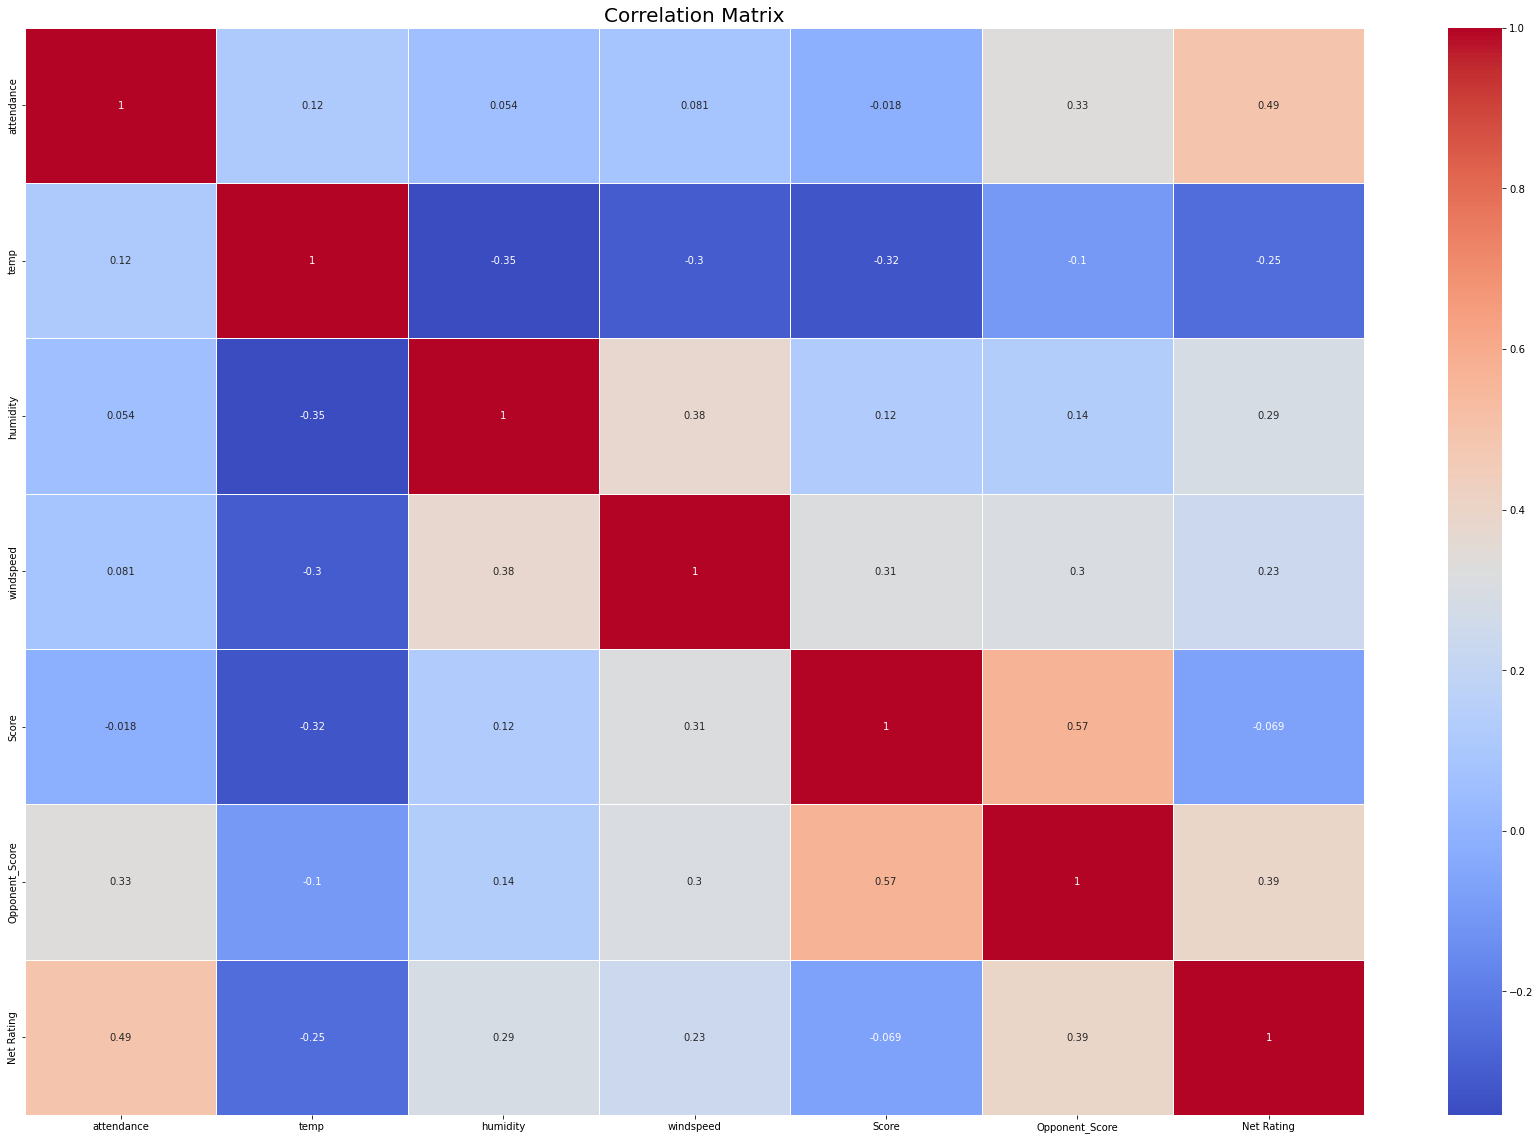

In [1278]:
#checking correlation

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = final_df.corr()

plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix', fontsize=20)
plt.show()


In [1138]:
attendance_by_game1 = final_df.groupby('game_time')['attendance'].sum()
attendance_by_game1

game_time
Afternoon    1107
Evening      3714
Name: attendance, dtype: int32

In [913]:
weather_data_needed[weather_data_needed['datetime'] == '2023-04-08']

,datetime,temp,tempmax,tempmin,humidity,conditions,icon,windspeed
189,2023-04-08,15.5,20.5,12.2,71.3,Clear,clear-day,17.5


In [1194]:
import warnings
warnings.filterwarnings('ignore')

In [1232]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Assuming the dataframe is named 'df'
# Define categorical and numeric columns
categorical_columns = ["icon", "game_time", "month", "Opponent"]
numeric_columns = ["temp", "humidity", "windspeed", "Score", "Opponent_Score","Net Rating", "is_weekend"]

# Preprocess the data
encoder = OneHotEncoder(handle_unknown="ignore")
scaler = StandardScaler()
column_transformer = ColumnTransformer(transformers=[
    ("cat", encoder, categorical_columns),
    ("num", scaler, numeric_columns)
], remainder="passthrough")

X = column_transformer.fit_transform(final_df[categorical_columns + numeric_columns])

# Extract target variable
y = final_df["attendance"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define regression models
models = [
    ("Linear Regression", LinearRegression(), {}),
    ("Ridge", Ridge(), {"alpha": [0.1, 1, 10]}),
    ("Lasso", Lasso(), {"alpha": [0.1, 1, 10]}),
    ("Decision Tree", DecisionTreeRegressor(), {"max_depth": [2, 5, 10]}),
    ("Random Forest", RandomForestRegressor(random_state=42), {"n_estimators": [10, 50, 100], "max_depth": [2, 5, 10]}),
    ("Support Vector Machines", SVR(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    ("K-Nearest Neighbors", KNeighborsRegressor(), {"n_neighbors": [3, 5, 7]}),
    ("XGBoost", XGBRegressor(), {"n_estimators": [50, 100, 150], "learning_rate": [0.01, 0.1, 0.2]})
]

# Evaluate each model with hyperparameter tuning
results = []
for name, model, params in models:
    grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, rmse, r2, grid_search.best_params_))

# Output the results in a well-organized manner
results_df = pd.DataFrame(results, columns=["Model", "MSE", "RMSE", "R2", "Best Parameters"])
results_df.sort_values("RMSE", ascending=True, inplace=True)
print(results_df)


                     Model           MSE        RMSE         R2  \
4            Random Forest    815.142564   28.550702   0.301933   
6      K-Nearest Neighbors    970.603499   31.154510   0.168801   
2                    Lasso   1012.179965   31.814776   0.133196   
5  Support Vector Machines   1066.459179   32.656687   0.086712   
7                  XGBoost   1372.684367   37.049755  -0.175531   
1                    Ridge   1374.424308   37.073229  -0.177021   
3            Decision Tree   1484.392857   38.527819  -0.271195   
0        Linear Regression  13531.568517  116.325270 -10.588082   

                              Best Parameters  
4       {'max_depth': 2, 'n_estimators': 100}  
6                          {'n_neighbors': 7}  
2                               {'alpha': 10}  
5                {'C': 1, 'kernel': 'linear'}  
7  {'learning_rate': 0.1, 'n_estimators': 50}  
1                               {'alpha': 10}  
3                            {'max_depth': 2}  
0           

In [1282]:
random_forest_model = None
for name, model, params in models:
    if name == "Random Forest":
        random_forest_model = model
        break

best_params = results_df.loc[results_df["Model"] == "Random Forest", "Best Parameters"].values[0]
random_forest_model.set_params(**best_params)
random_forest_model.fit(X_train, y_train)

importances = random_forest_model.feature_importances_

encoded_categorical_columns = column_transformer.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_features = np.concatenate([encoded_categorical_columns, numeric_columns])

feature_importances_df = pd.DataFrame({"Feature": all_features, "Importance": importances})

feature_importances_df.sort_values("Importance", ascending=False, inplace=True)

print("Feature importances for the Random Forest model:")
print(feature_importances_df)


Feature importances for the Random Forest model:
                            Feature  Importance
40                       Net Rating    0.292659
38                            Score    0.133914
39                   Opponent_Score    0.126864
37                        windspeed    0.119883
13           Opponent_Brooklyn Nets    0.088137
36                         humidity    0.044697
35                             temp    0.041038
10                    month_October    0.040703
29            Opponent_Phoenix Suns    0.018366
30        Opponent_Sacramento Kings    0.015940
8                       month_March    0.015157
25    Opponent_New Orleans Pelicans    0.013642
17        Opponent_Dallas Mavericks    0.011519
41                       is_weekend    0.007630
5                    month_December    0.006116
3               game_time_Afternoon    0.005058
6                    month_February    0.003850
12          Opponent_Boston Celtics    0.003593
20         Opponent_Houston Rockets    

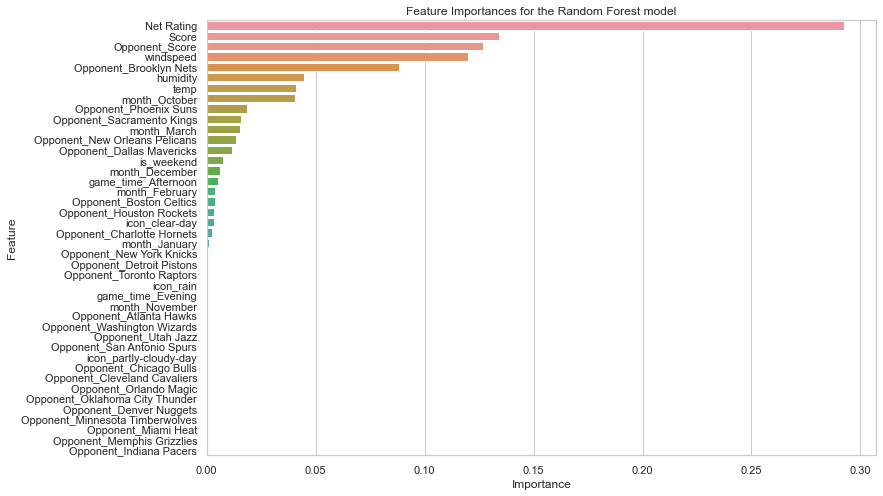

In [1283]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

sns.barplot(x="Importance", y="Feature", data=feature_importances_df)

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances for the Random Forest model")

plt.show()


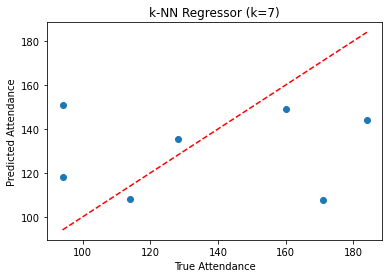

In [1198]:
k=7

plt.scatter(y_test, y_pred)
plt.xlabel("True Attendance")
plt.ylabel("Predicted Attendance")
plt.title(f"k-NN Regressor (k={k})")

diagonal = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
plt.plot(diagonal, diagonal, 'r--')

plt.show()

In [1237]:
results_df

,Model,MSE,RMSE,R2,Best Parameters
4,Random Forest,815.142564,28.550702,0.301933,"{'max_depth': 2, 'n_estimators': 100}"
6,K-Nearest Neighbors,970.603499,31.154510,0.168801,{'n_neighbors': 7}
2,Lasso,1012.179965,31.814776,0.133196,{'alpha': 10}
5,Support Vector Machines,1066.459179,32.656687,0.086712,"{'C': 1, 'kernel': 'linear'}"
7,XGBoost,1372.684367,37.049755,-0.175531,"{'learning_rate': 0.1, 'n_estimators': 50}"
1,Ridge,1374.424308,37.073229,-0.177021,{'alpha': 10}
3,Decision Tree,1484.392857,38.527819,-0.271195,{'max_depth': 2}
0,Linear Regression,13531.568517,116.325270,-10.588082,{}


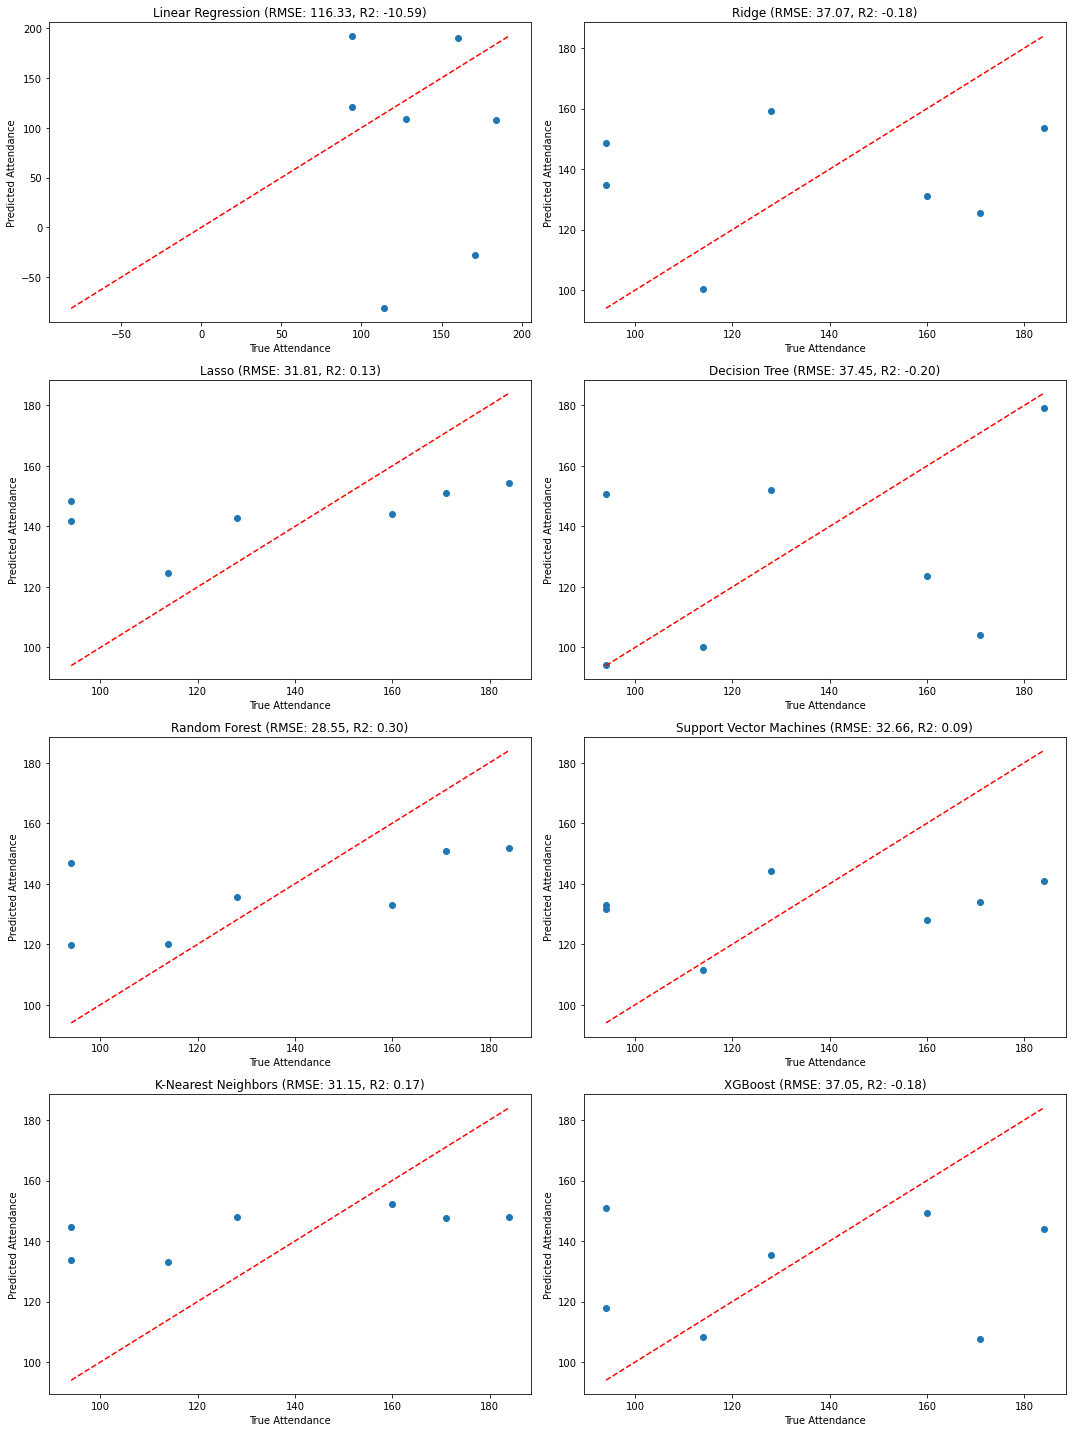

In [1234]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, (name, model, params) in enumerate(models):
    grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    ax = axes[i]
    ax.scatter(y_test, y_pred)
    ax.set_title(f"{name} (RMSE: {rmse:.2f}, R2: {r2:.2f})")
    ax.set_xlabel("True Attendance")
    ax.set_ylabel("Predicted Attendance")
    
    diagonal = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
    ax.plot(diagonal, diagonal, 'r--')

plt.tight_layout()
plt.savefig("all_models.png", dpi=800, bbox_inches='tight')
plt.show()


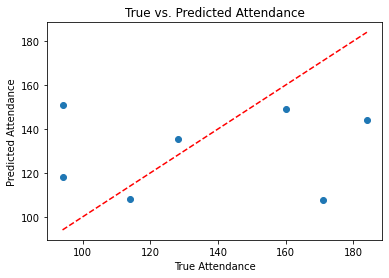

In [1225]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("True Attendance")
plt.ylabel("Predicted Attendance")
plt.title("True vs. Predicted Attendance")

diagonal = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
plt.plot(diagonal, diagonal, 'r--')

plt.show()


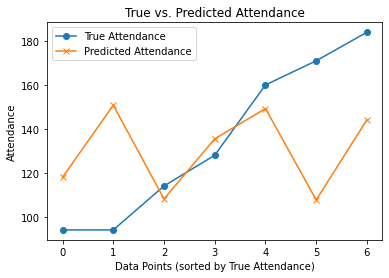

In [1229]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

sorted_indices = np.argsort(y_test)
y_test_sorted = y_test.iloc[sorted_indices].reset_index(drop=True)
y_pred_sorted = y_pred[sorted_indices]

plt.plot(y_test_sorted, label="True Attendance", linestyle='-', marker='o')
plt.plot(y_pred_sorted, label="Predicted Attendance", linestyle='-', marker='x')
plt.xlabel("Data Points (sorted by True Attendance)")
plt.ylabel("Attendance")
plt.title("True vs. Predicted Attendance")
plt.legend()
plt.savefig("true_vs_predicted_attendance.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#Average Score: 110.67647058823529
#Average Opponent Score: 108.8529411764706
#categorical_columns = ["icon", "game_time", "month", "Opponent"]
#numeric_columns = ["temp", "humidity", "windspeed", "Score", "Opponent_Score","Net Rating", "is_weekend"]


In [1255]:
new_data = pd.DataFrame({
    "icon": ["clear-day"],
    "game_time": ["Evening"],
    "month": ["April"],
    "Opponent": ["Portland Trail Blazers"],
    "temp": [15.5],
    "humidity": [71.3],
    "windspeed": [17.5],
    "Score": [110],
    "Opponent_Score":[108],
    "Net Rating": [-4.0], 
    "is_weekend": [1]
    
})

X_new = column_transformer.transform(new_data)

y_new_pred = best_model.predict(X_new)

print("Predicted attendance:", y_new_pred[0])


Predicted attendance: 139.63159


In [1258]:
merged_result.head(1)

,game_number,datetime,attendance,temp,tempmax,tempmin,humidity,icon,windspeed,game_time,weekday,month,Date,Time,Box Score,Game_num,Away/Home,Opponent,W/L,Score,Opponent_Score,Wins,Losses,Streak,consecutive_home
0,1,2022-10-23,244,17.6,21.8,14.3,68.0,clear-day,13.1,Evening,Sunday,October,"Sun, Oct 23, 2022",10:00p,Box Score,Game 1,Home,Phoenix Suns,L,95,112,2,1,L 1,1


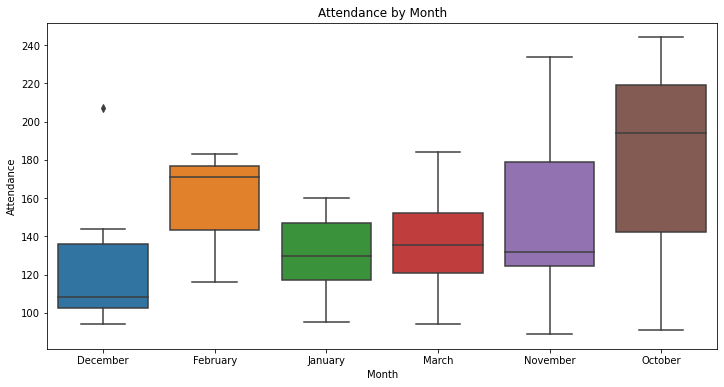

In [1259]:


attendance_by_month_and_game = merged_result.groupby(['month', 'game_number'])['attendance'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(data=attendance_by_month_and_game, x='month', y='attendance')
plt.title('Attendance by Month')
plt.xlabel('Month')
plt.ylabel('Attendance')

plt.show()


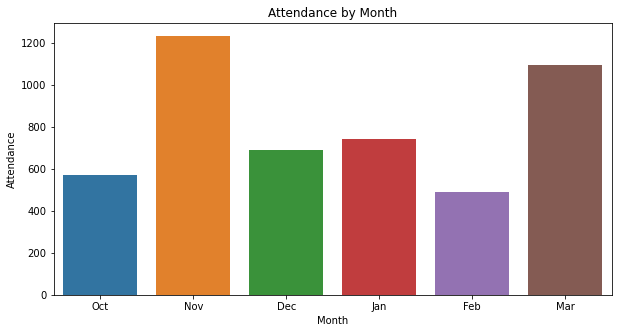

In [1267]:

attendance_by_month_and_game = merged_result.groupby(['month', 'game_number'])['attendance'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=month_names, y=attendance_by_month.values)
plt.xlabel("Month")
plt.ylabel("Attendance")
plt.title("Attendance by Month")
plt.show()

# Attendance of USP Members 

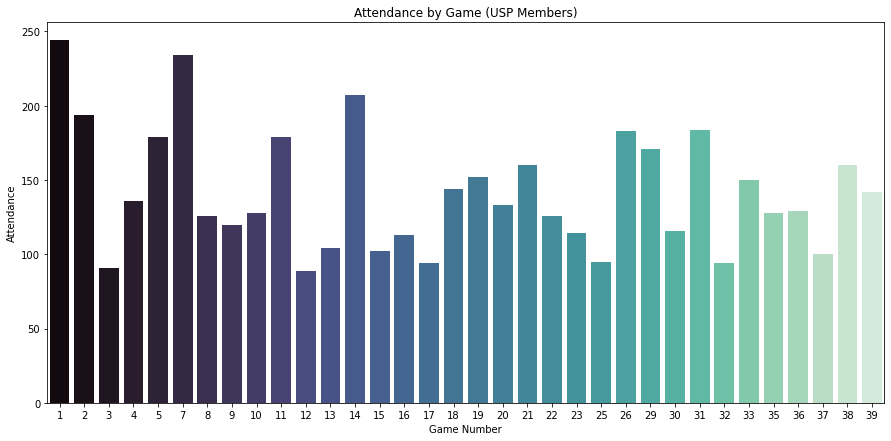

In [1264]:

attendance_by_game = merged_result.groupby('game_number')['attendance'].sum()

plt.figure(figsize=(15, 7))
sns.barplot(x=attendance_by_game.index, y=attendance_by_game.values, palette='mako')
plt.xlabel("Game Number")
plt.ylabel("Attendance")
plt.title("Attendance by Game (USP Members)")
plt.show()


# For Single Game Buyers

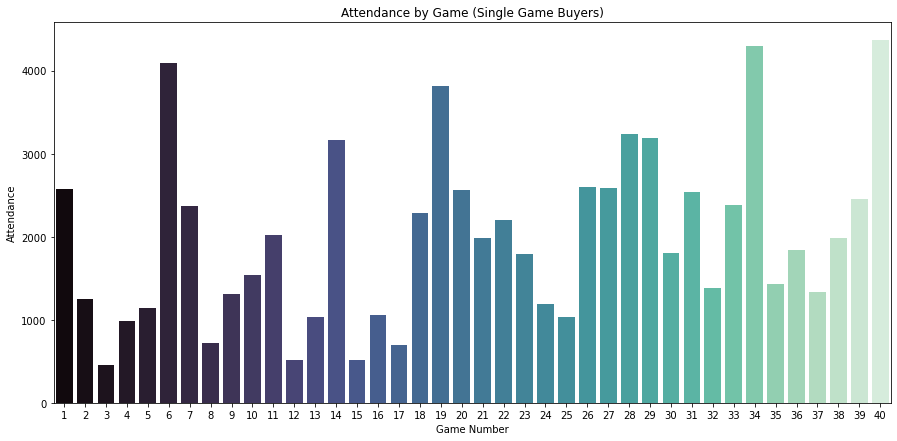

In [1271]:

attendance_by_game_single = game_data.groupby('game_number')['scan_datetime'].count()

plt.figure(figsize=(15, 7))
sns.barplot(x=attendance_by_game.index, y=attendance_by_game.values, palette='mako')
plt.xlabel("Game Number")
plt.ylabel("Attendance")
plt.title("Attendance by Game (Single Game Buyers)")
plt.show()

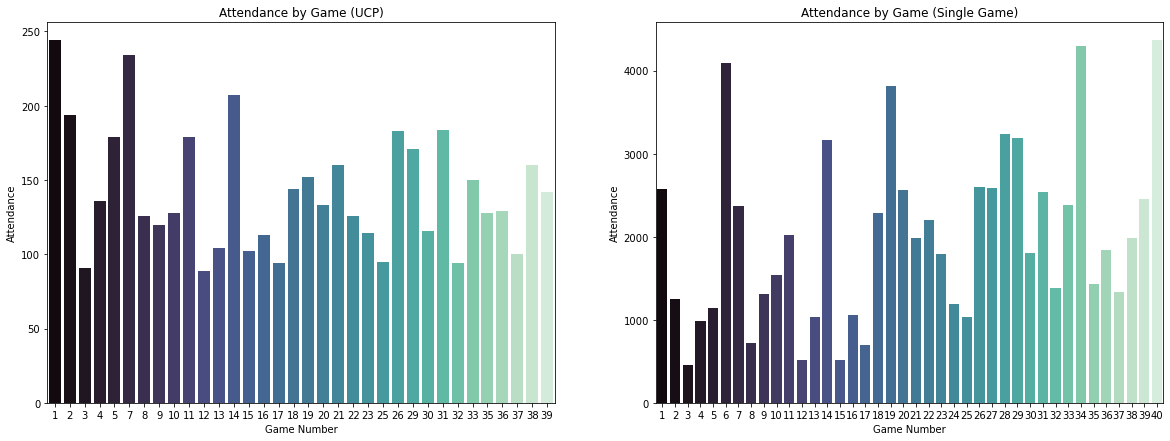

In [1266]:
import matplotlib.pyplot as plt
import seaborn as sns

attendance_by_game_sample = merged_result.groupby('game_number')['attendance'].sum()
attendance_by_game_data = game_data.groupby('game_number')['scan_datetime'].count()

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

sns.barplot(x=attendance_by_game_sample.index, y=attendance_by_game_sample.values, palette='mako', ax=axes[0])
axes[0].set_xlabel("Game Number")
axes[0].set_ylabel("Attendance")
axes[0].set_title("Attendance by Game (UCP)")

sns.barplot(x=attendance_by_game_data.index, y=attendance_by_game_data.values, palette='mako', ax=axes[1])
axes[1].set_xlabel("Game Number")
axes[1].set_ylabel("Attendance")
axes[1].set_title("Attendance by Game (Single Game)")

plt.show()


In [1273]:
merged_result.groupby('weekday')['attendance'].mean().reset_index()


,weekday,attendance
0,Friday,158.666667
1,Monday,149.833333
2,Saturday,141.428571
3,Sunday,156.285714
4,Thursday,108.500000
5,Tuesday,135.000000
6,Wednesday,130.750000


In [1276]:
merged_result.groupby('game_time')['attendance'].mean().reset_index()


,game_time,attendance
0,Afternoon,138.375000
1,Evening,142.846154


In [1286]:
UCP_Member_Report1=UCP_Member_Report.copy()

In [1287]:
UCP_Member_Report1.dropna(inplace=True)

In [1289]:
df=UCP_Member_Report1

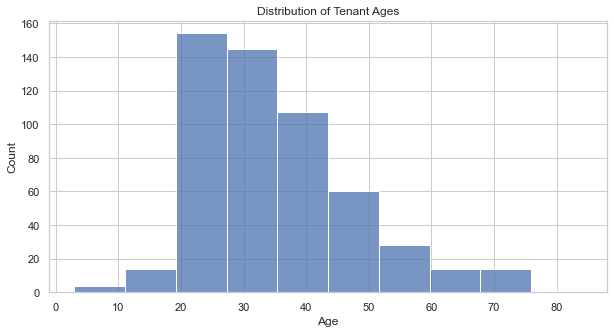

In [1290]:
now = datetime.now()
df["BIRTHDATE"] = pd.to_datetime(df["BIRTHDATE"])
df["AGE"] = (now - df["BIRTHDATE"]).astype('<m8[Y]').astype(int)

plt.figure(figsize=(10, 5))
sns.histplot(df["AGE"], bins=10, kde=False)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Tenant Ages")
plt.show()

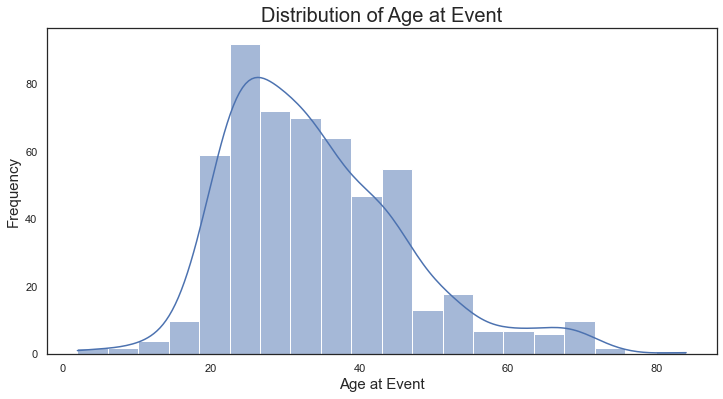

In [1293]:
df["MEMBER_SINCE"] = pd.to_datetime(df["MEMBER_SINCE"])
df["age_at_event"] = (df["MEMBER_SINCE"] - df["BIRTHDATE"]).astype('<m8[Y]').astype(int)

sns.set_style("white")

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age_at_event', kde=True, bins=20)

plt.title('Distribution of Age at Event', fontsize=20)
plt.xlabel('Age at Event', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()
